# Task 2: Quantum Errors - Bit Flip and Phase Flip

In [1]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error

%matplotlib inline

## Part 2.1: Circuit to Generate the Bell State  

Creating the following bell state using the given quantum circuit:  

$$\left|\Psi\right\rangle = \frac{\left|00\right\rangle + \left|11\right\rangle}{\sqrt2}$$

1. The Hadamard gate creates a superposition state
2. The Controlled Not gate entangles the two qubits

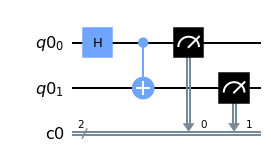

In [2]:
# initialize the circuit with two Classical and Quantum Bits
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

# Creating the Bell State
circuit.h(qr[0])
circuit.cx(qr[0], qr[1])

# Measuring the two qubits
circuit.measure(qr, cr)
circuit.draw(output='mpl')

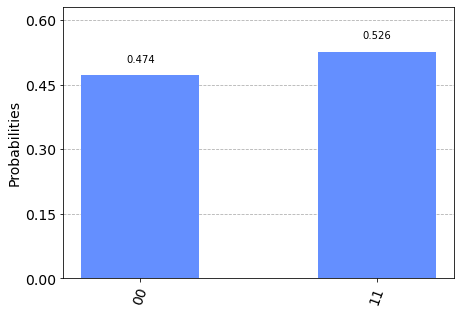

In [3]:
# Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator).result()

# Plotting the Simulation results
plot_histogram(result.get_counts(circuit))

The results after measuring the two qubits of the bell state $|\psi\rangle$ gives us the expexted results of the states $|00\rangle$ and $|11\rangle$ with a probability of about about 50% for each.

The states $|01\rangle$ and $|10\rangle$ are not obtained when the gates are ideal with no noise present in the circuit.

## Part 2.2: Introducing Error before the CNOT gate

This part requires us to indroduce an "Error Gate" just before the C-NOT gate. The "Error Gate" performs a Phase Flip (Z Gate) with probability p1 and Bit Flip (X Gate) with probabitlity p2.  

I have implemented this random "Error Gate" using non-ideal(noisy) Identity gates just before the C-NOT gate. To simulate the noisy Identity Gate, I've used the NoiseModel class provided in qiskit Aer.

The Identity Gate in addition to the Identity operation introduces an error by either flipping the phase or flipping the bit with some non zero probabilities.

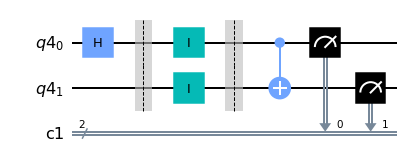

In [4]:
# initialize circuit with Classical and Quantum Bits
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.barrier()

# "Error Gate" implemented by a noisy Identity gate
circuit.id(qr[:])
circuit.barrier()

circuit.cx(qr[0], qr[1])
circuit.measure(qr, cr)

circuit.draw(output='mpl')

Noise Model on the Identity gate:
 - X with Probability = bit_flip_prob
 - Z with Probability = phase_flip_prob
 - I with Probability = 1 - bit_flip_prob - phase_flip_prob

In [5]:
def noise_model(phase_flip_prob, bit_flip_prob):
    '''
    phase_flip_prob: Probability of a phase flip occuring
    bit_flip_prob: Probability of a bit flip occuring
    '''

    # Defining the types of error and the probabilities with which they can occur in a particular gate
    error_gate = pauli_error([('X', bit_flip_prob), ('Z', phase_flip_prob), ('I', 1 - bit_flip_prob - phase_flip_prob)])

    # Creating a noise_model object
    noise_model = NoiseModel()
    
    # Adding noise to the Identity to simulate noise between two gates(channel noise)
    noise_model.add_all_qubit_quantum_error(error_gate, ["id"])
    
    return noise_model

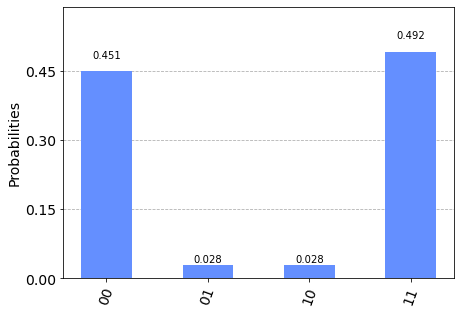

In [6]:
# Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')
phase_bit_flip = noise_model(phase_flip_prob = 0.05, bit_flip_prob = 0.05)
result = execute(circuit, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
plot_histogram(result.get_counts(circuit))

As we can see here, the measurement results obtained include the terms $|01\rangle$ and $|10\rangle$ apart from the terms corresponding to the Bell state. The noise between the Hadamard gate and the C-NOT gate have resulted in non-zero probabilities for obtaining the states $|01\rangle$ and $|10\rangle$.  

The states $|00\rangle$ and $|11\rangle$ are obtained with equal probabilitites and their probabilities are large compared to the probabilites for obtaining the $|01\rangle$ and $|10\rangle$ states.

## Part 2.3: Quantum Error Correction: Bit Flip Code and Phase Flip Code

### a) Bit Flip Code: 
We use ancilla qubits to create entangled states and oberve the parity between them to identify bit flip errors. The 

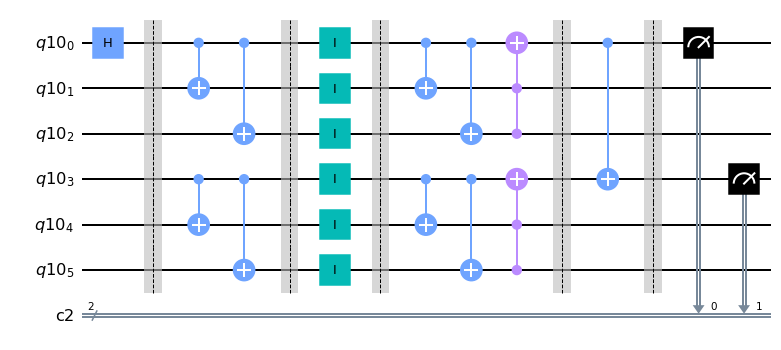

In [7]:
# initialize circuit with Classical and Quantum Bits
qr = QuantumRegister(6)
cr = ClassicalRegister(2)

BFC = QuantumCircuit(qr, cr)

BFC.h(qr[0])
BFC.barrier()

# C-NOT Gates for the bit flip code
BFC.cx(qr[0], qr[1])
BFC.cx(qr[0], qr[2])
BFC.cx(qr[3], qr[4])
BFC.cx(qr[3], qr[5])

BFC.barrier()

# Non-Ideal Identity Gates
BFC.id(qr[:])

BFC.barrier()

# C-NOT Gates for the Bit Flip Code
BFC.cx(qr[0], qr[1])
BFC.cx(qr[0], qr[2])
BFC.ccx(qr[1], qr[2], qr[0])
BFC.cx(qr[3], qr[4])
BFC.cx(qr[3], qr[5])
BFC.ccx(qr[4], qr[5], qr[3])

BFC.barrier()

BFC.cx(qr[0], qr[3])

BFC.barrier()

BFC.measure([qr[0], qr[3]], cr)

BFC.draw(output='mpl')

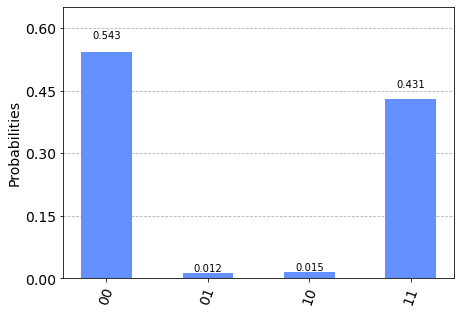

In [8]:
# Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')
bit_flip_error = noise_model(phase_flip_prob = 0, bit_flip_prob = 0.1)
result = execute(BFC, backend = simulator, noise_model = bit_flip_error).result()

# Plotting the Simulation results
plot_histogram(result.get_counts(BFC))

### b) Phase Flip Code

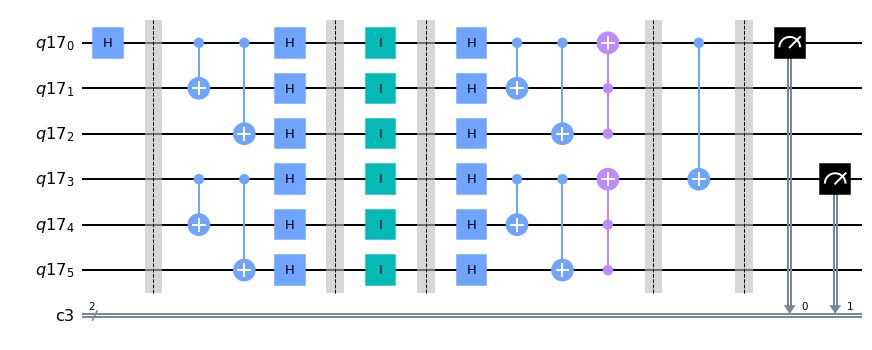

In [9]:
# initialize basic circuit with Classical and Quantum Bits
qr = QuantumRegister(6)
cr = ClassicalRegister(2)

PFC = QuantumCircuit(qr, cr)

PFC.h(qr[0])
PFC.barrier()

PFC.cx(qr[0], qr[1])
PFC.cx(qr[0], qr[2])
PFC.cx(qr[3], qr[4])
PFC.cx(qr[3], qr[5])
PFC.h(qr[:])

PFC.barrier()

PFC.id(qr[:])

PFC.barrier()

PFC.h(qr[:])
PFC.cx(qr[0], qr[1])
PFC.cx(qr[0], qr[2])
PFC.ccx(qr[1], qr[2], qr[0])
PFC.cx(qr[3], qr[4])
PFC.cx(qr[3], qr[5])
PFC.ccx(qr[4], qr[5], qr[3])

PFC.barrier()

PFC.cx(qr[0], qr[3])

PFC.barrier()

PFC.measure([qr[0], qr[3]], cr)

PFC.draw(output='mpl')

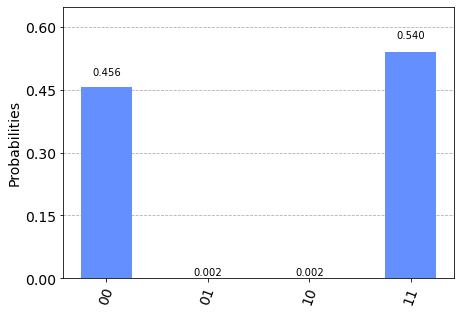

In [10]:
# Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')
phase_flip_error = noise_model(phase_flip_prob = 0.05, bit_flip_prob = 0)
result = execute(PFC, backend = simulator, noise_model = phase_flip_error).result()

# Plotting the Simulation results
plot_histogram(result.get_counts(PFC))

### c) Shor Code: For correcting Bit Flip Errors or Phase Flip Errors or Both

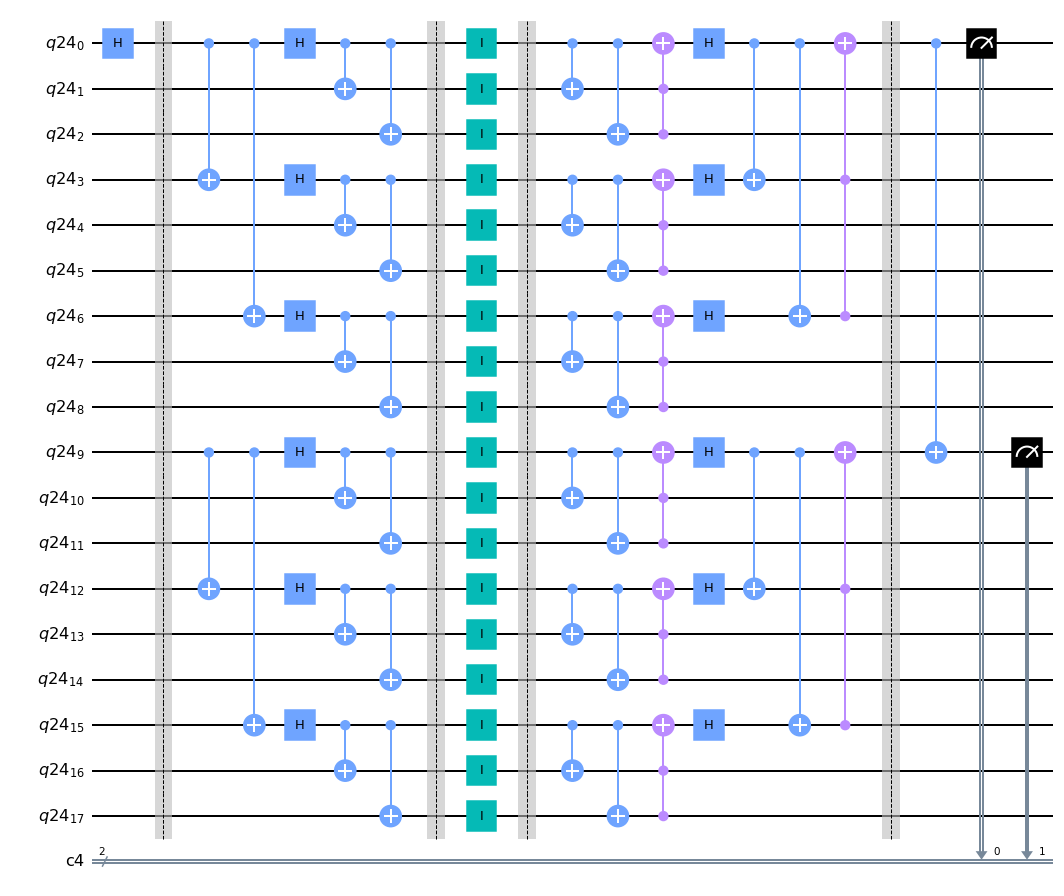

In [11]:
# initialize basic circuit with Classical and Quantum Bits
qr = QuantumRegister(18)
cr = ClassicalRegister(2)

shor = QuantumCircuit(qr, cr)

shor.h(qr[0])

shor.barrier()

shor.cx(qr[0], qr[3])
shor.cx(qr[0], qr[6])
shor.cx(qr[9], qr[12])
shor.cx(qr[9], qr[15])

shor.h(qr[0])
shor.h(qr[3])
shor.h(qr[6])
shor.h(qr[9])
shor.h(qr[12])
shor.h(qr[15])

shor.cx(qr[0], qr[1])
shor.cx(qr[0], qr[2])
shor.cx(qr[3], qr[4])
shor.cx(qr[3], qr[5])
shor.cx(qr[6], qr[7])
shor.cx(qr[6], qr[8])
shor.cx(qr[9], qr[10])
shor.cx(qr[9], qr[11])
shor.cx(qr[12], qr[13])
shor.cx(qr[12], qr[14])
shor.cx(qr[15], qr[16])
shor.cx(qr[15], qr[17])

shor.barrier()

shor.id(qr[:])

shor.barrier()

shor.cx(qr[0], qr[1])
shor.cx(qr[0], qr[2])
shor.ccx(qr[1], qr[2], qr[0])
shor.cx(qr[3], qr[4])
shor.cx(qr[3], qr[5])
shor.ccx(qr[4], qr[5], qr[3])
shor.cx(qr[6], qr[7])
shor.cx(qr[6], qr[8])
shor.ccx(qr[8], qr[7], qr[6])
shor.cx(qr[9], qr[10])
shor.cx(qr[9], qr[11])
shor.ccx(qr[10], qr[11], qr[9])
shor.cx(qr[12], qr[13])
shor.cx(qr[12], qr[14])
shor.ccx(qr[13], qr[14], qr[12])
shor.cx(qr[15], qr[16])
shor.cx(qr[15], qr[17])
shor.ccx(qr[17], qr[16], qr[15])

shor.h(qr[0])
shor.h(qr[3])
shor.h(qr[6])
shor.h(qr[9])
shor.h(qr[12])
shor.h(qr[15])

shor.cx(qr[0], qr[3])
shor.cx(qr[0], qr[6])
shor.cx(qr[9], qr[12])
shor.cx(qr[9], qr[15])

shor.ccx(qr[3], qr[6], qr[0])
shor.ccx(qr[12], qr[15], qr[9])

shor.barrier()

shor.cx(qr[0], qr[9])

shor.measure([qr[0], qr[9]], cr)

shor.draw(output='mpl')

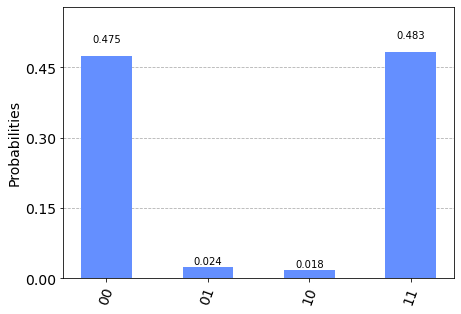

In [12]:
# Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')

# Reusing the noise model from part 2.2 to compare performace of the Shor Code with the Vanilla Circuit
result = execute(shor, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
plot_histogram(result.get_counts(shor))

## Part 2.4: Comparision of the Shor Code for different error probabilities

### Test 1:
**Bit Flip - 1%**  
**Phase Flip - 1%**

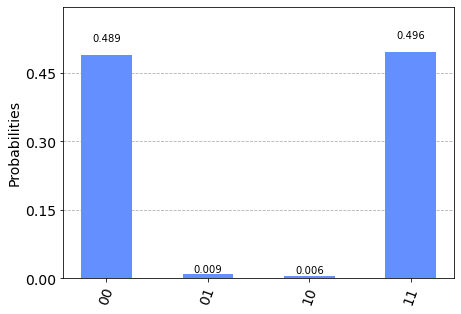

In [13]:
# Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')
phase_bit_flip = noise_model(phase_flip_prob = 0.01, bit_flip_prob = 0.01)
result = execute(circuit, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
plot_histogram(result.get_counts(circuit))

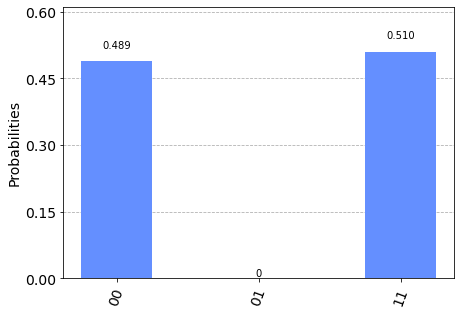

In [14]:
# Reusing the noise model from part 2.2 to compare performace of the Shor Code with the Vanilla Circuit
result = execute(shor, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
plot_histogram(result.get_counts(shor))

### Test 2:
**Bit Flip - 5%**  
**Phase Flip - 5%**

Vanilla Circuit without Error Correction


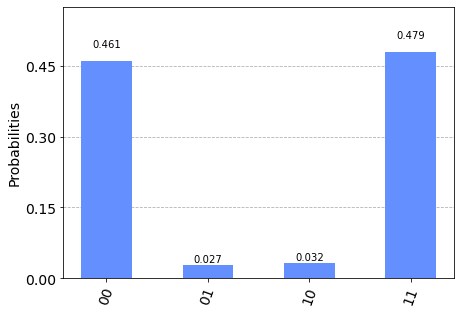

In [15]:
# Simulating the quantum circuit
phase_bit_flip = noise_model(phase_flip_prob = 0.05, bit_flip_prob = 0.05)
result = execute(circuit, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Vanilla Circuit without Error Correction")
plot_histogram(result.get_counts(circuit))

Circuit with Shor Code


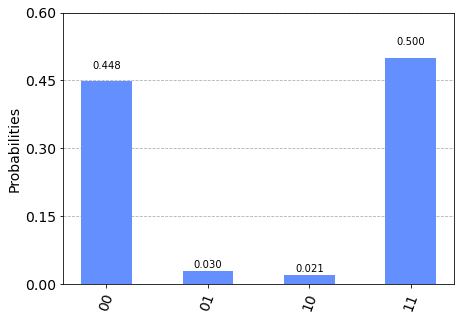

In [16]:
# Reusing the noise model from part 2.2 to compare performace of the Shor Code with the Vanilla Circuit
result = execute(shor, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Circuit with Shor Code")
plot_histogram(result.get_counts(shor))

### Test 3:
**Bit Flip - 10%**  
**Phase Flip - 10%**

Vanilla Circuit without Error Correction


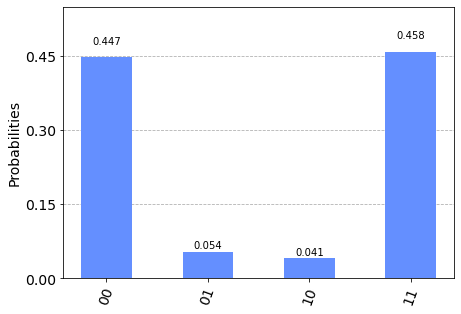

In [17]:
# Simulating the quantum circuit
phase_bit_flip = noise_model(phase_flip_prob = 0.1, bit_flip_prob = 0.1)
result = execute(circuit, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Vanilla Circuit without Error Correction")
plot_histogram(result.get_counts(circuit))

Circuit with Shor Code


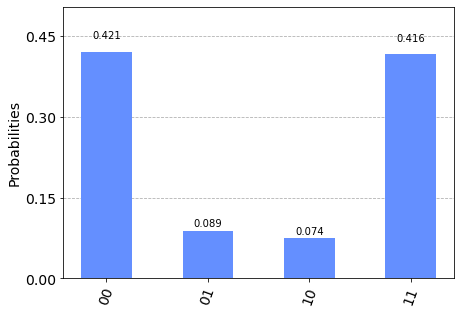

In [18]:
# Reusing the noise model from part 2.2 to compare performace of the Shor Code with the Vanilla Circuit
result = execute(shor, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Circuit with Shor Code")
plot_histogram(result.get_counts(shor))

From the above plots, we can infer that for low probabilities of an error occuring, the Shor Code corrects the error introduced. As the probabilty of error increases, the chances that an error occurs in more than one qubit (including ancilla qubits) is high, resulting in a wrong state at the output of the circuit even after applying the Error Correction Code. 

In Example 1, with error probabilities of 1%, the Shor Code improved the probabilities of obtaining the correct state at the output.  
In Example 2, with error probabilities of 5%, the Shor Code did not bring about a significant improvement in the measurement results.  
In Example 3, with error probabilities of 10%, the Shor Code did a poor job of correcting the error. In fact, it increased the probability of getting a wrong result. 

## References

1. Qiskit Foundations - Coding with Qiskit: https://www.youtube.com/playlist?list=PLOFEBzvs-Vvp2xg9-POLJhQwtVktlYGbY
2. Qiskit Textbook on QEC: https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html
3. Quantum Noise in Qiskit: https://qiskit.org/documentation/apidoc/aer_noise.html
4. Intro to Error Correction: https://qiskit.org/learn/intro-qc-qh/
5. Wikipedia Page on QEC: https://en.wikipedia.org/wiki/Quantum_error_correction